In [69]:
import pandas as pd

In [70]:
from scipy.stats import boxcox
df = pd.read_csv('processed_data.csv', index_col=False)


In [71]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from skopt.space import Real, Categorical, Integer
import xgboost
import pickle as pkl
import xgboost as xgb
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectFromModel

params = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'), # the step size shrinkage used in update to prevent overfitting
    'max_depth': Integer(1, 50), # The maximum depth of a tree
#     'max_delta_step': Real(0, 20), # regularisation incase of unbalanced classes
    'reg_lambda': Real(1e-3, 1000, 'log-uniform'), # regularisation analagous to lambda in ridge regression
    'reg_alpha': Real(1e-3, 1.0, 'log-uniform'), # regularisation analagous to lambda in LASSO regression
    'gamma': Real(1e-3, 0.5, 'log-uniform'), # Gamma specifies the minimum loss reduction required to make a split
    'min_child_weight': Real(1, 10), # analogous to minimum number of samples per split
    'n_estimators': Integer(50, 100), # number of trees in the ensemble
    'scale_pos_weight': Real(1e-3, 500, 'log-uniform') #controls the balance of positive and negative weights, useful for imbalanced classes.
}

In [72]:
target = 'price'
exclude = ['host_name', 'host_id', 'id', 'name', 'neighbourhood',  'n_group', 'availability_365',
           'room_type', 'days_since_last_review', 'last_review', 'reviews_per_month', 'price', 
           'days_since_last_review']
box_cox_columns = ['minimum_nights','number_of_reviews', 
                     'calculated_host_listings_count']
features = [i for i in df.columns 
                if df[i].dtype!='object'
#                 and not
#                 (
#                          i.startswith('neighbourhood') 
#                      or i.startswith('n_group') 
#                      or i.startswith('name')
#                      or i.startswith('room_type')
#                 )
                and i not in exclude 
               ]
print(features)
print(len(features))

['room_type_Private room', 'name_room', 'n_group_brooklyn', 'name_private', 'n_group_queens', 'name_cozy', 'neighbourhood_bushwick', 'avail_low', 'neighbourhood_bedford-stuyvesant', 'room_type_Shared room', 'name_bushwick', 'number_of_reviews', 'n_group_bronx', 'neighbourhood_washington heights', 'name_sunny', 'name_shared', 'name_brooklyn', 'neighbourhood_harlem', 'neighbourhood_crown heights', 'name_jfk', 'name_train', 'neighbourhood_ridgewood', 'neighbourhood_flatbush', 'neighbourhood_sunnyside', 'neighbourhood_flushing', 'neighbourhood_elmhurst', 'neighbourhood_east flatbush', 'neighbourhood_astoria', 'neighbourhood_kips bay', 'neighbourhood_nolita', 'neighbourhood_gramercy', 'neighbourhood_east village', 'neighbourhood_murray hill', 'name_1br', 'neighbourhood_upper east side', 'neighbourhood_theater district', 'name_exchange', 'name_stock', 'name_designer', 'name_suite', 'name_terrace', 'latitude', 'name_sonder', 'name_doorman', 'neighbourhood_financial district', 'name_2ba', 'nam

In [73]:
from scipy.special import  inv_boxcox
from scipy.stats import boxcox


def box_cox(X_train, X_test, y_train, numerical_columns, target): # try PowerTransformer for this next time
    lam={}
    for i in X_train.columns:
        if i in numerical_columns:
            X_train[i], lam[i] = boxcox(X_train[i])
            X_test[i] = boxcox(X_test[i], lmbda=lam[i])
    y_train, lam[target] = boxcox(y_train)
    return X_train, X_test, y_train, lam

def transform_data(X_train, X_test, y_train, numerical_columns, target):
    for i in numerical_columns:
        if 0 in X_train[i] or 0 in X_test[i]:
            X_train[i] = X_train[i]+1.01
            X_test[i] = X_test[i]+1.01
    y_train = y_train+1.01
    X_train_bc, X_test_bc, y_train_bc, lam = box_cox(X_train, X_test, y_train, numerical_columns, target)
    return X_train_bc, X_test_bc, y_train_bc, lam

def inv_transform_pred(y_pred, lam, target):
    return inv_boxcox(y_pred, lam[target])-1.01

In [74]:
X_t, X_test, y_t, y_test = train_test_split(df[features], df[target], test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.1, random_state=1)


In [75]:
X_t, X_test, y_t, lam = transform_data(X_t, X_test, y_t, box_cox_columns, target)
y_test = boxcox(y_test+1.01, lmbda=lam[target])

In [76]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

xgb_pipe = Pipeline(steps=[('rs',RobustScaler()), 
                           ('reg',xgb.XGBRegressor(objective='reg:pseudohubererror'))])
for old_key in list(params.keys()):
    params[f'reg__{old_key}'] = params[old_key]
    del params[old_key]

In [77]:

kf = KFold(n_splits=5,random_state=1,shuffle=True)
bayes=BayesSearchCV(estimator = xgb_pipe, search_spaces=params, n_iter=50, scoring='neg_mean_absolute_error',
                    cv=kf.split(X_t,y_t), random_state=42, n_jobs = -1, verbose=1)
res=bayes.fit(X_t, y_t)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [78]:
# save the model to disk
model_filename = 'best_model_final.xz'
pkl.dump(res.best_estimator_, open(model_filename, 'wb'))

In [79]:
# load the model from disk
loaded_model = pkl.load(open(model_filename, 'rb'))

In [107]:
loaded_model.fit(X_t, y_t)
y_pred = loaded_model.predict(X_test)
accuracy = mean_absolute_error(y_test, y_pred)
print(f'MAE: {accuracy}')

MAE: 0.13239999200158337


In [108]:
accuracy = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {accuracy}')

MAPE: 0.08210876099775487


<AxesSubplot:>

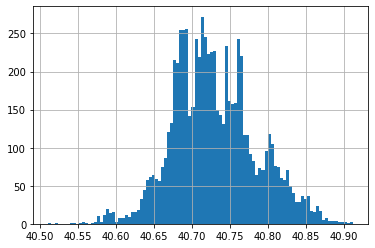

In [81]:
X_test['latitude'].hist(bins=100)

In [82]:
import shap
explainer = shap.TreeExplainer(loaded_model[1])
X_test_df = pd.DataFrame(X_test, columns=features)

shap_values = explainer.shap_values(X_test_df)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [83]:
shap.initjs()

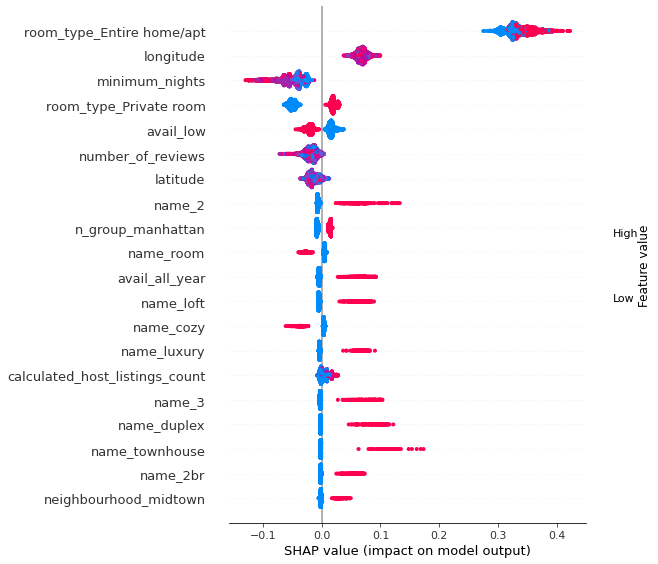

In [84]:
shap.summary_plot(shap_values, X_test_df)

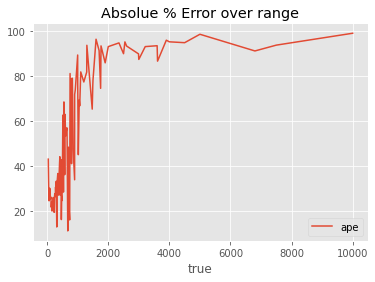

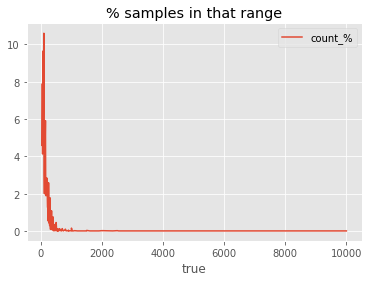

In [101]:
import matplotlib.pyplot as plt
import matplotlib
pe_inv = inv_transform_pred(y_test, lam, target) - inv_transform_pred(y_pred, lam, target)
er_df = pd.DataFrame({'err': pe_inv, 'true':inv_transform_pred(y_test, lam, target)})
er_df['bin'] = er_df['true']//10
er_df['abs_err'] = er_df['err'].abs()
er_df_grp = er_df.groupby(['bin'])[['abs_err', 'true']].mean()
er_df_grp['count'] = er_df.groupby(['bin'])['true'].count()
er_df_grp['ape'] = er_df_grp['abs_err']/er_df_grp['true']*100
er_df_grp['count_%'] = er_df_grp['count']/er_df_grp['count'].sum() *100
er_df_grp = er_df_grp[er_df_grp['true']>30]
matplotlib.style.use('ggplot')

er_df_grp.set_index('true')[['ape']].plot()
plt.title('Absolue % Error over range')
plt.show()
er_df_grp.set_index('true')[[ 'count_%']].plot()
plt.title('% samples in that range')
plt.show()


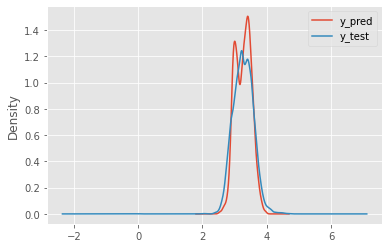

In [106]:
d = pd.DataFrame({'y_pred':y_pred, 'y_test':y_test})
d.plot.kde()
plt.show()

In [98]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, median_absolute_error

mean_absolute_percentage_error(y_test, y_pred)

0.08210876099775487

In [96]:
lam[target]

-0.16441040996748846

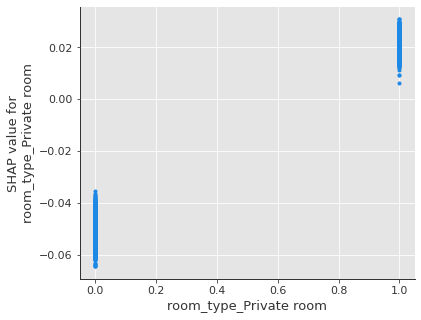

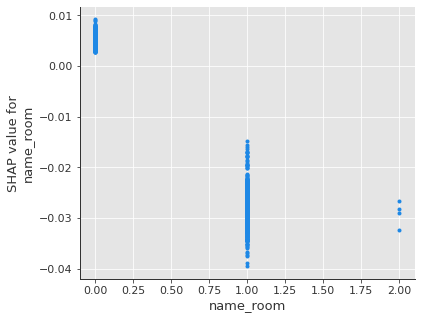

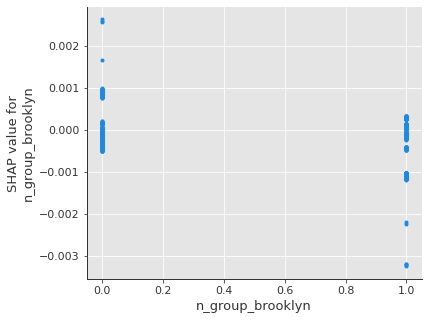

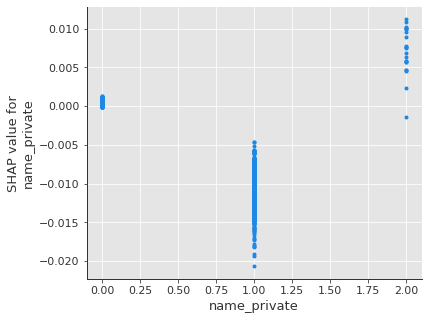

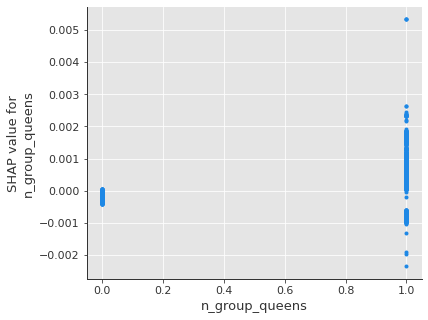

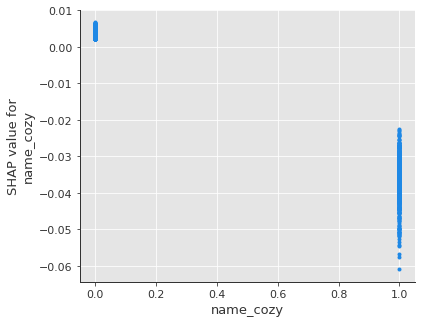

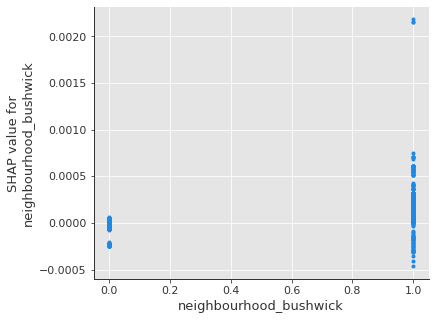

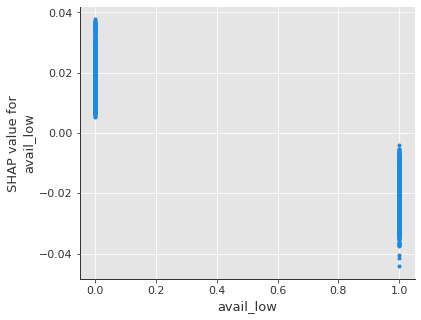

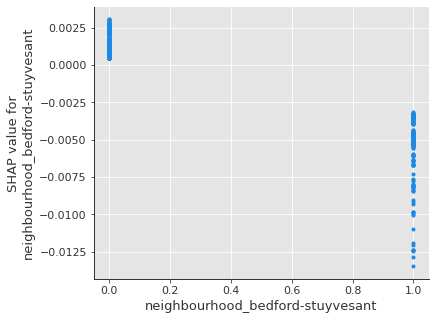

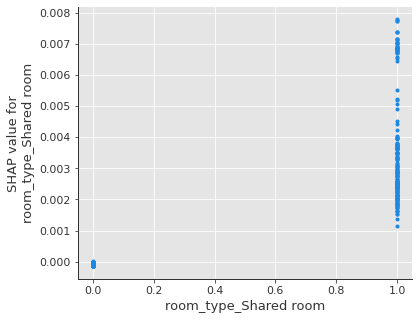

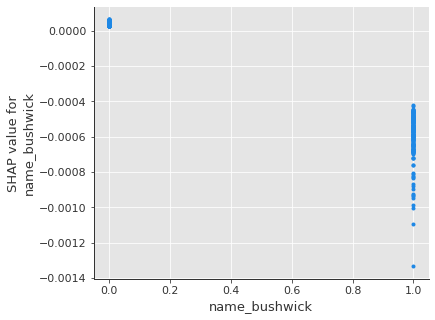

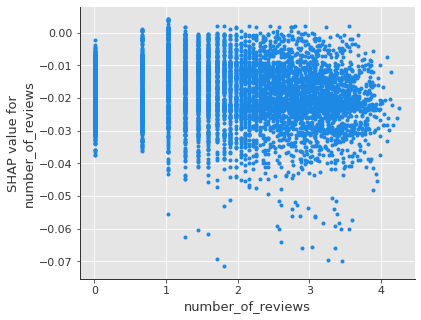

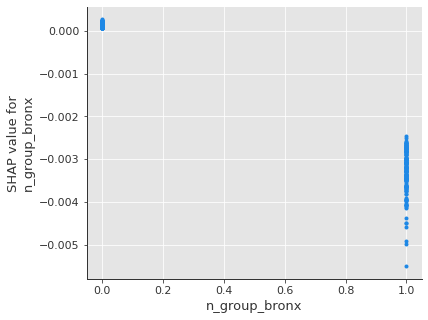

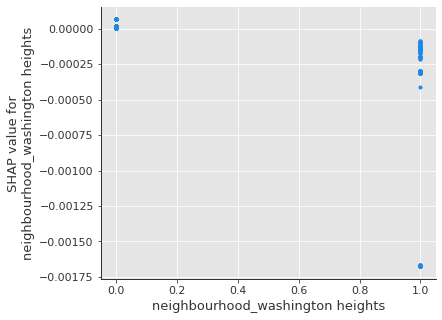

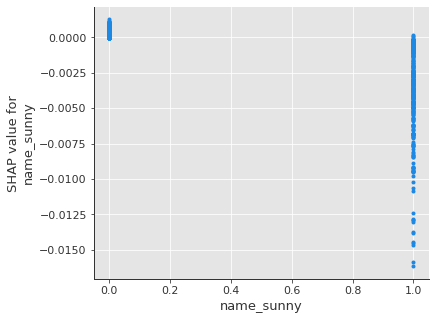

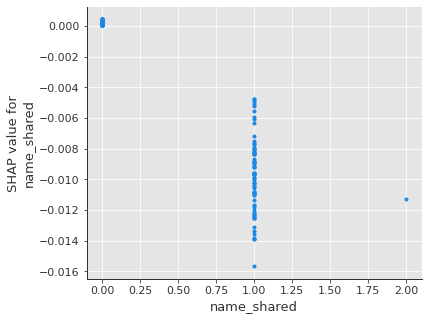

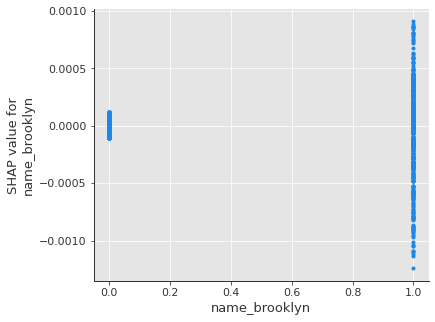

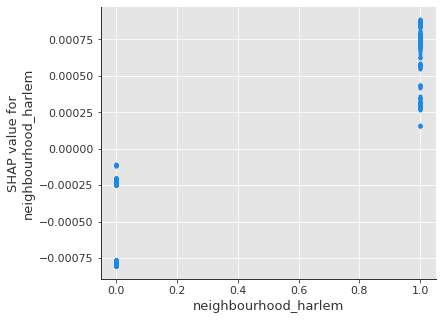

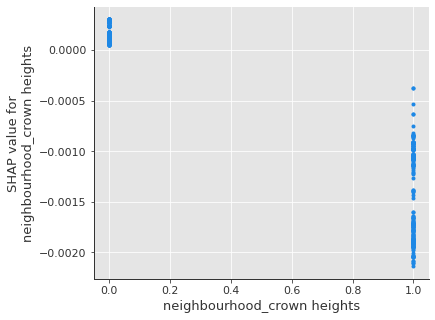

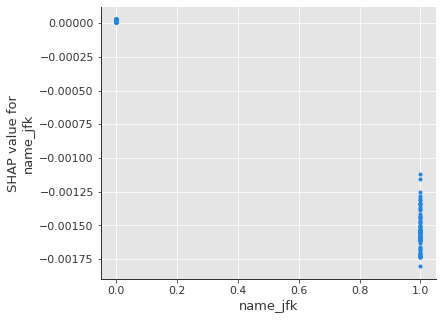

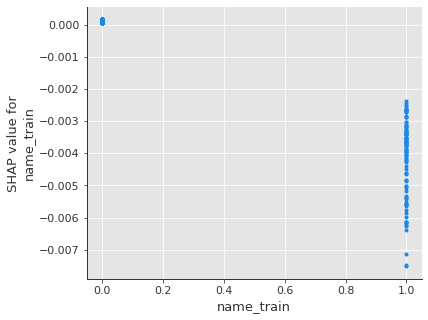

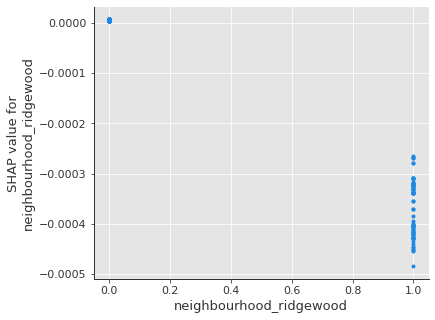

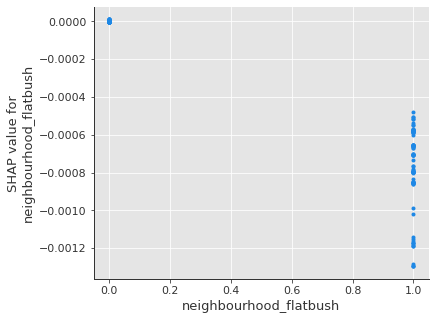

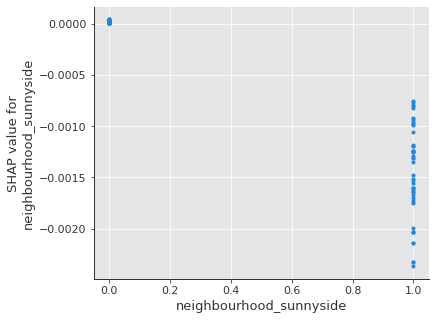

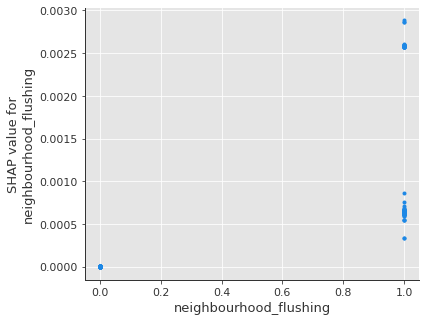

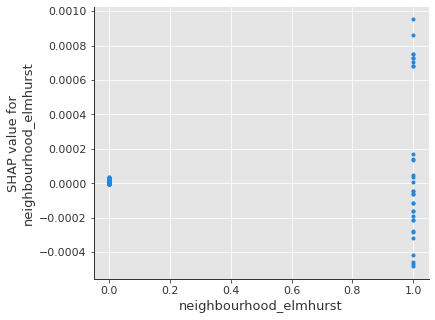

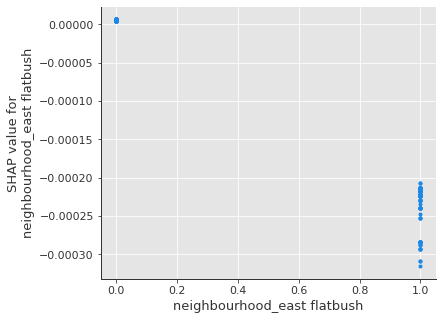

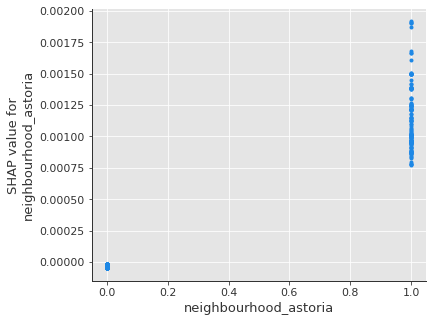

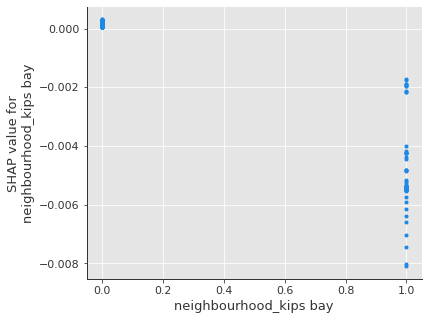

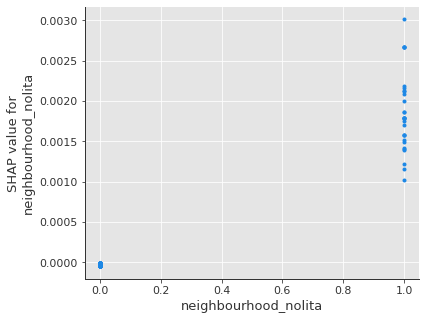

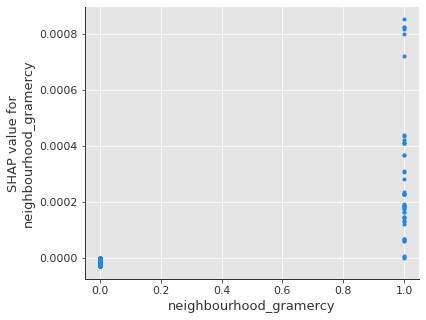

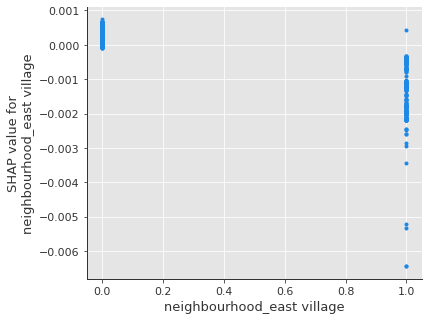

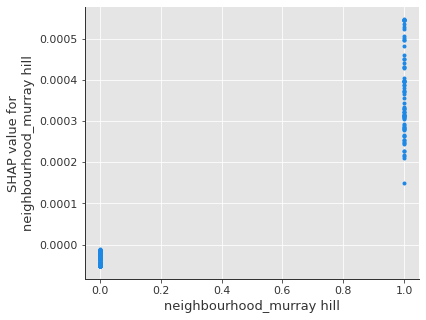

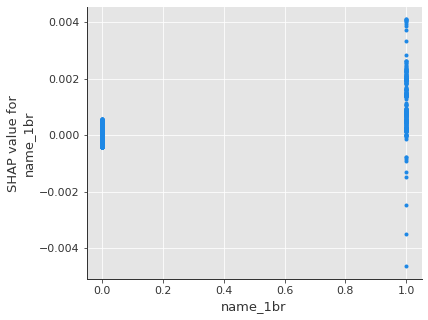

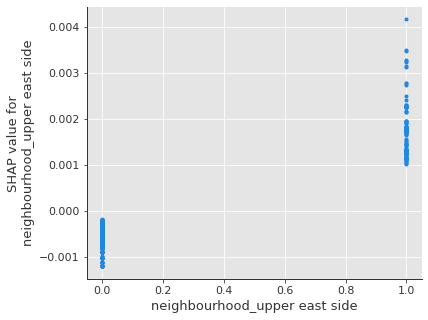

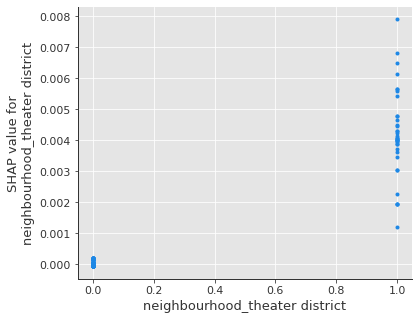

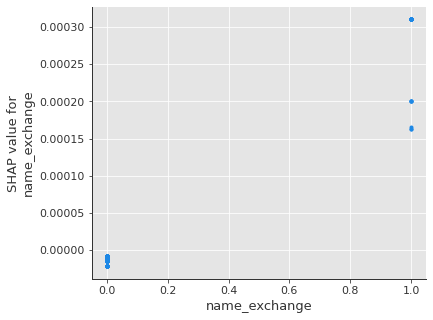

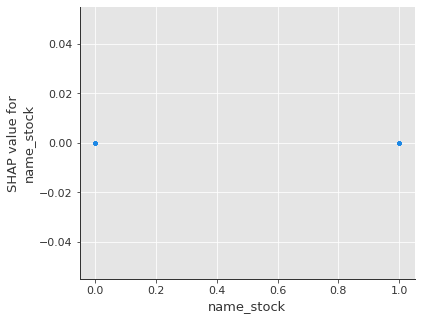

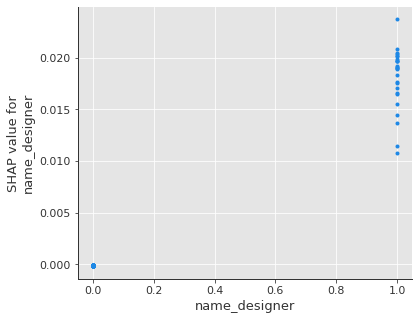

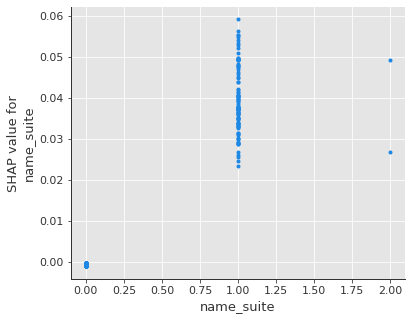

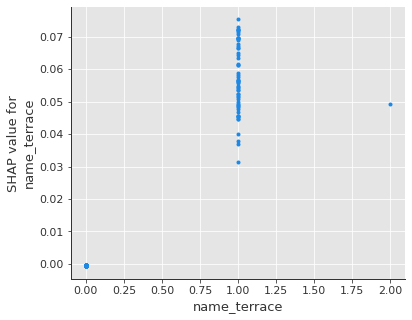

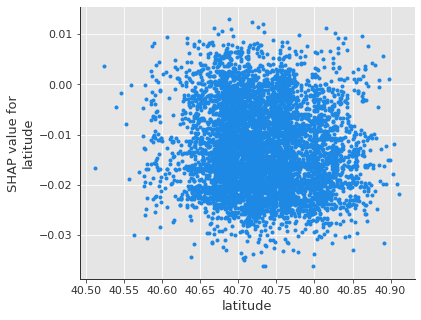

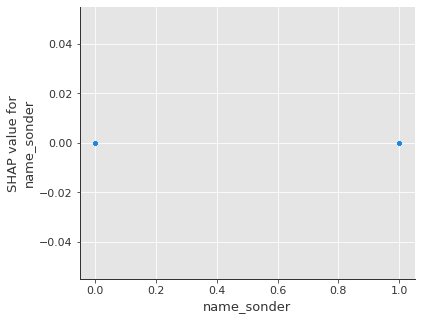

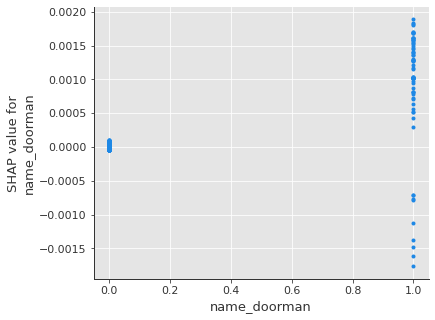

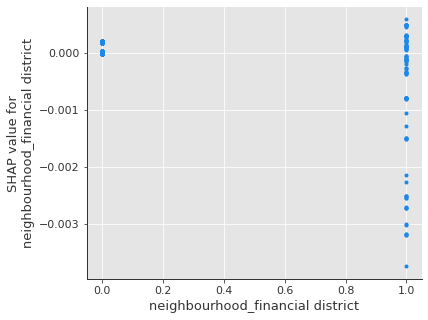

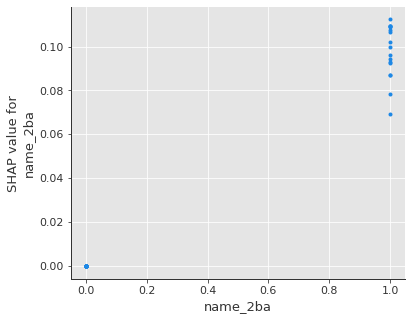

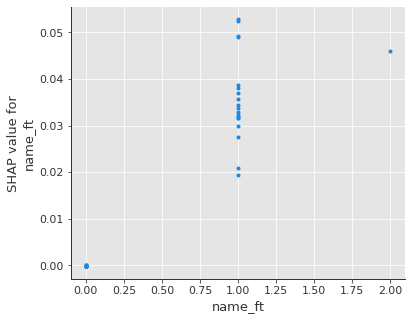

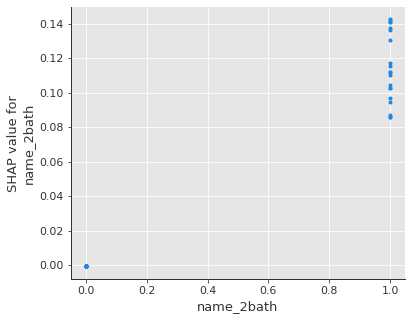

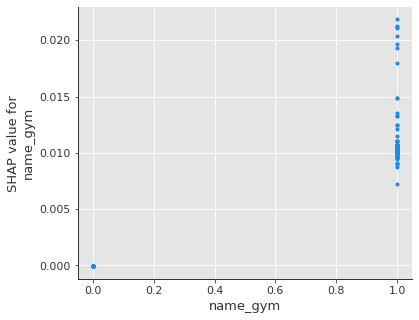

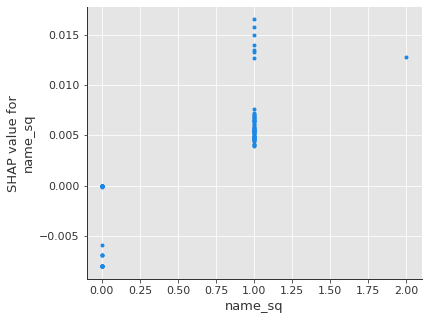

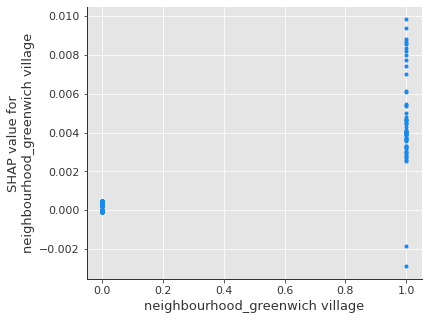

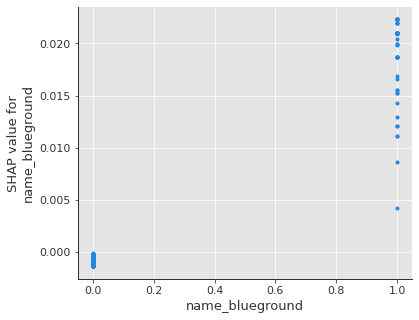

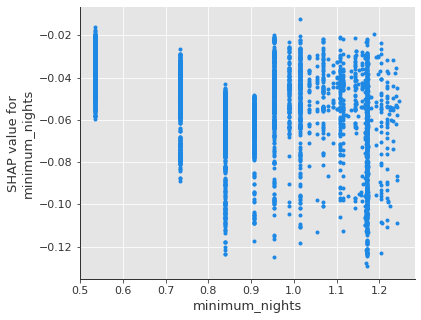

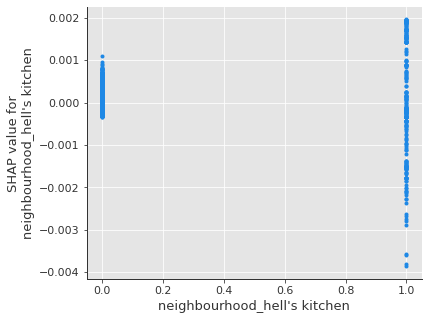

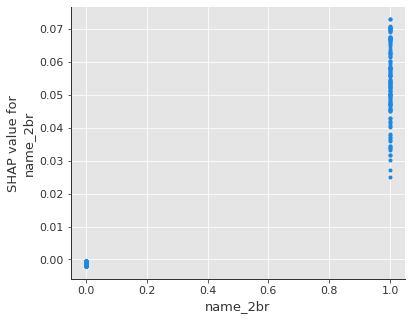

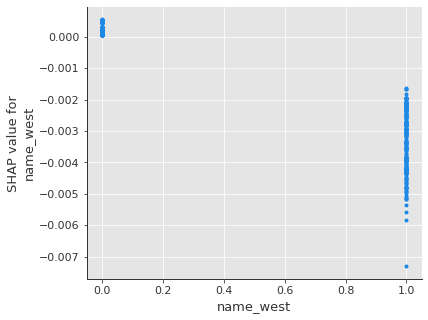

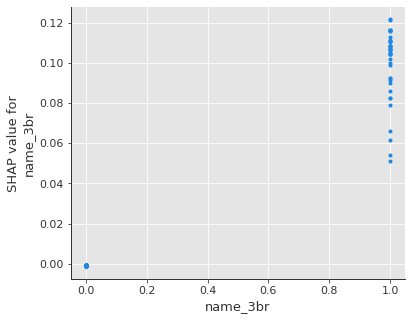

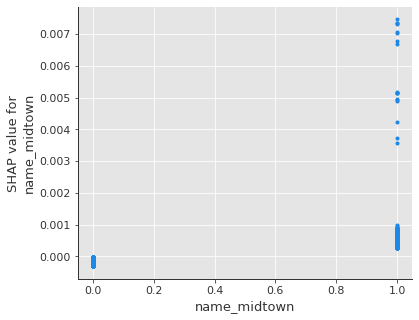

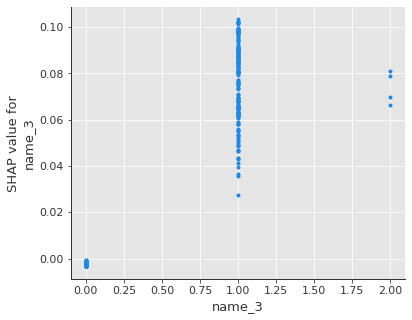

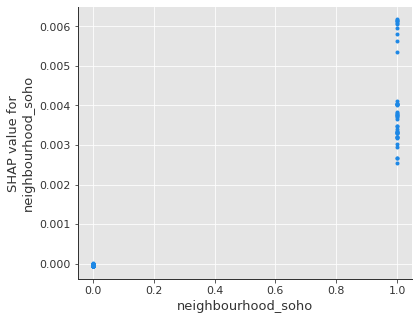

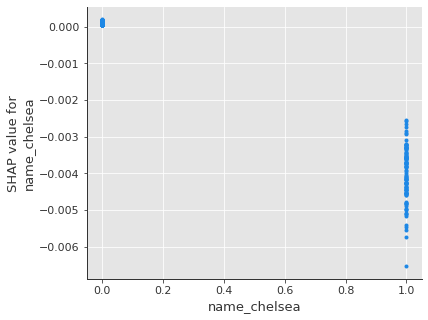

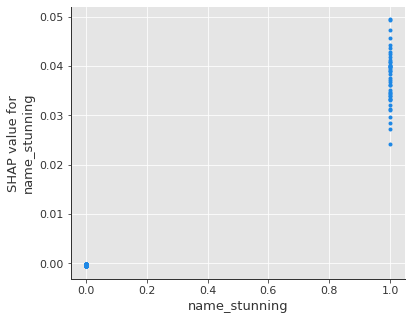

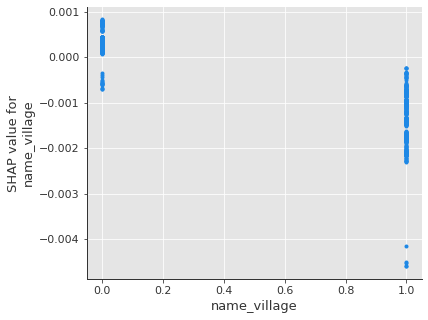

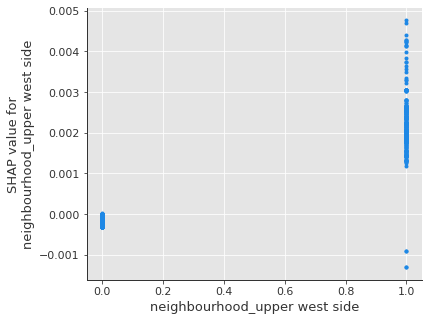

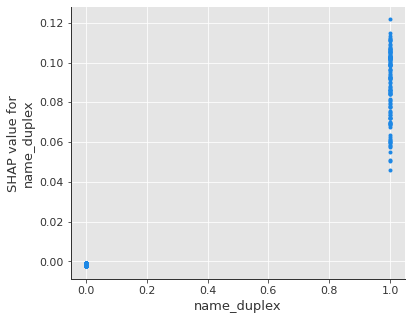

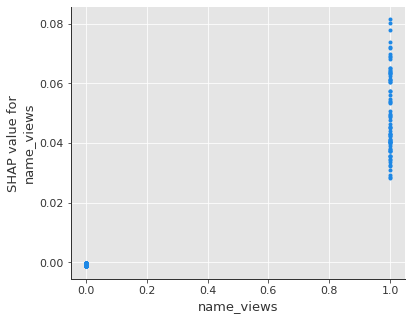

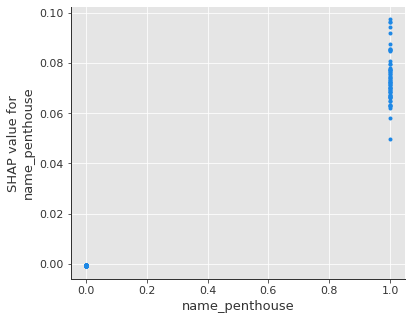

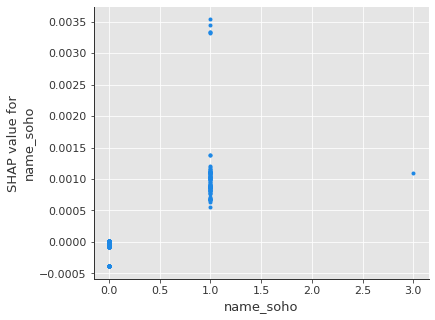

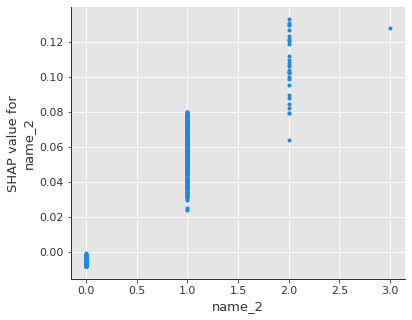

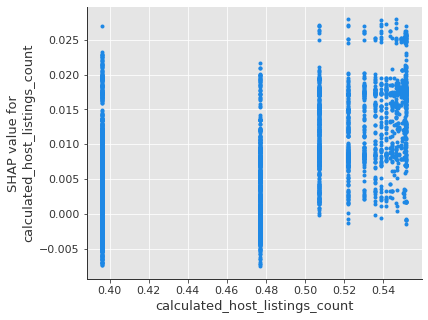

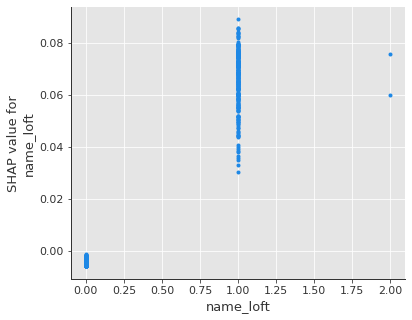

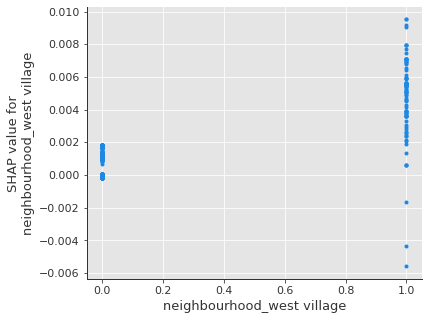

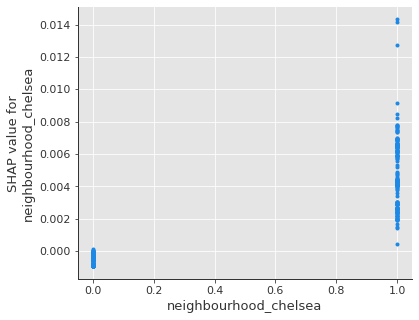

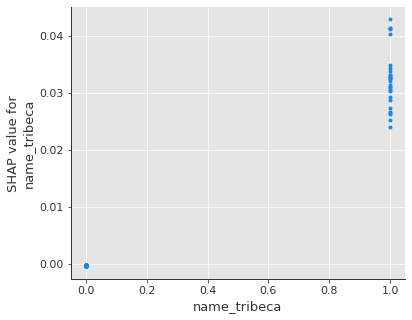

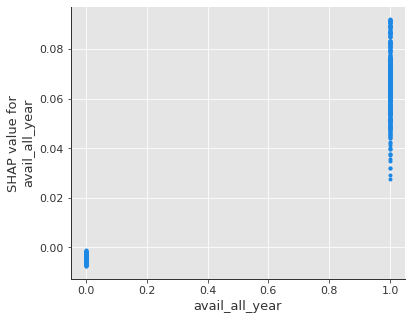

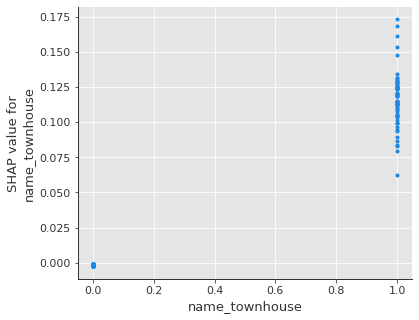

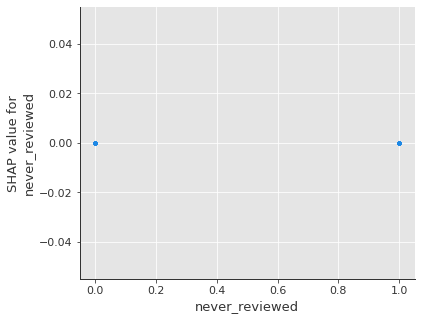

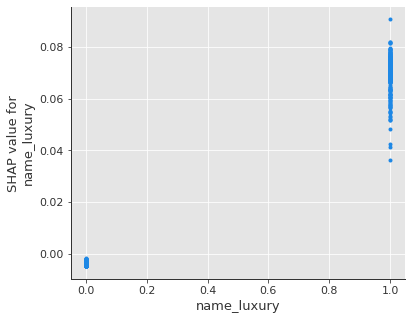

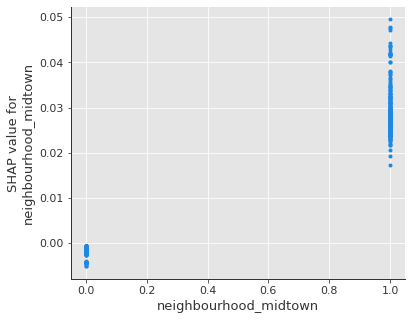

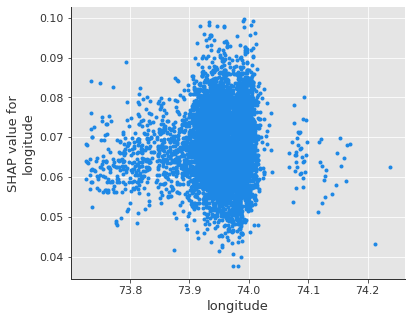

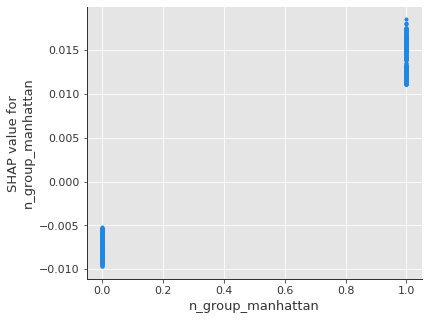

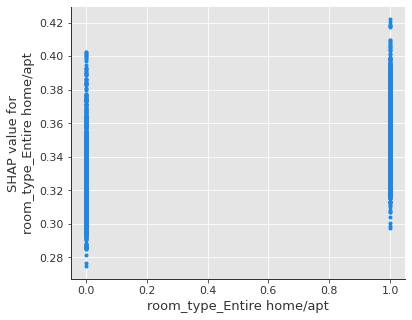

In [102]:
for name in X_test_df.columns:
    shap.dependence_plot(name, shap_values, X_test_df, interaction_index=None)